In [28]:
!pip install pandas numpy scikit-learn matplotlib yfinance

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


In [39]:
# Get user input for stock ticker
ticker = input("Enter the stock ticker symbol (e.g., 'AAPL' for Apple): ")

# Download stock data
stock_data = yf.download(ticker, start='2010-01-01', end='2023-01-01')

# Display the first few rows of the data
stock_data.head()


Enter the stock ticker symbol (e.g., 'AAPL' for Apple): UBER


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-10,42.000000,45.000000,41.060001,41.570000,41.570000,186322500
2019-05-13,38.790001,39.240002,36.080002,37.099998,37.099998,79442400
2019-05-14,38.310001,39.959999,36.849998,39.959999,39.959999,46661100
2019-05-15,39.369999,41.880001,38.950001,41.290001,41.290001,36086100
2019-05-16,41.480000,44.060001,41.250000,43.000000,43.000000,38115500


In [31]:
# Handle missing values
stock_data = stock_data.dropna()

# Create moving averages
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()

# Drop rows with NaN values generated by moving averages
stock_data = stock_data.dropna()

# Display the updated dataframe
stock_data.head()



,Open,High,Low,Close,Adj Close,Volume,MA_50,MA_200
Date,,,,,,,,
2021-09-27,175.000000,176.319000,172.020004,174.259995,174.259995,3551400,153.658799,163.36000
2021-09-28,172.516006,173.559998,166.899994,168.580002,168.580002,4362800,154.392799,163.47935
2021-09-29,170.100006,171.220993,166.550003,168.070007,168.070007,2788700,155.032400,163.62345
2021-09-30,168.100006,169.500000,165.710007,167.750000,167.750000,2662500,155.602400,163.81220
2021-10-01,170.309998,173.199997,168.550003,173.009995,173.009995,4963000,156.273199,164.05325


In [32]:
# Select features and target variable
features = stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA_50', 'MA_200']]
target = stock_data['Close'].shift(-1)  # Predict the next day's closing price

# Drop the last row as it will have NaN in the target
features = features[:-1]
target = target[:-1]

# Display the features and target
features.head(), target.head()



(                  Open        High         Low       Close   Volume  \
 Date                                                                  
 2021-09-27  175.000000  176.319000  172.020004  174.259995  3551400   
 2021-09-28  172.516006  173.559998  166.899994  168.580002  4362800   
 2021-09-29  170.100006  171.220993  166.550003  168.070007  2788700   
 2021-09-30  168.100006  169.500000  165.710007  167.750000  2662500   
 2021-10-01  170.309998  173.199997  168.550003  173.009995  4963000   
 
                  MA_50     MA_200  
 Date                               
 2021-09-27  153.658799  163.36000  
 2021-09-28  154.392799  163.47935  
 2021-09-29  155.032400  163.62345  
 2021-09-30  155.602400  163.81220  
 2021-10-01  156.273199  164.05325  ,
 Date
 2021-09-27    168.580002
 2021-09-28    168.070007
 2021-09-29    167.750000
 2021-09-30    173.009995
 2021-10-01    164.500000
 Name: Close, dtype: float64)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [34]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [35]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate accuracy (R^2 score)
accuracy = r2_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Mean Squared Error: 38.319605234297754
Accuracy: 0.959698337040738


In [36]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Train the model with the best parameters
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200)

In [37]:
# Predict on test data with the best model
final_pred = best_model.predict(X_test)

# Calculate final MSE and accuracy
final_mse = mean_squared_error(y_test, final_pred)
final_accuracy = r2_score(y_test, final_pred)
print(f'Final Mean Squared Error: {final_mse}')
print(f'Final Accuracy: {final_accuracy}')



Final Mean Squared Error: 38.59498204405766
Final Accuracy: 0.9594087165369285


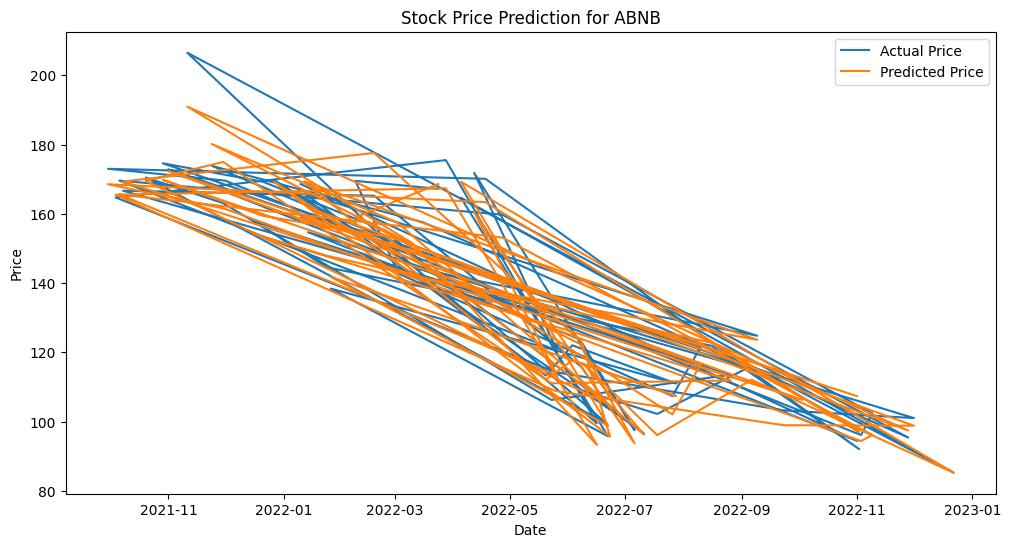

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, final_pred, label='Predicted Price')
plt.legend()
plt.title(f'Stock Price Prediction for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

